`page 262`

# Chapter 6

## Exercise 8

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from operator import itemgetter

from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder, scale, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

import statsmodels.api as sm
import patsy

# Glmnet Vignette
import glmnet_python
from glmnet import glmnet

# For viewing progress bar
from tqdm import tqdm, tnrange, tqdm_notebook

# interactive grid
import qgrid

In [2]:
# Debugging
%load_ext birdseye

In [146]:
X = np.random.normal(size=100)
y = 0.5 + 2*X - 5*(X**2) + 3*(X**3) + np.random.normal(size=100)

In [147]:
poly = PolynomialFeatures(degree=10, include_bias=False)
X_arr = poly.fit_transform(X[:, np.newaxis])

col_names = ['Y']+['X'+ str(i) for i in range(1, 11)]
df = pd.DataFrame(np.concatenate((y[:, np.newaxis], X_arr), axis=1), columns=col_names)

df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,-5.899804,-0.844948,0.713937,-0.603240,0.509707,-0.430676,0.363899,-0.307475,0.259801,-0.219518,0.185481
1,0.073227,0.855230,0.731419,0.625531,0.534973,0.457525,0.391289,0.334643,0.286196,0.244764,0.209329
2,-7.721759,-0.951812,0.905946,-0.862290,0.820738,-0.781189,0.743545,-0.707715,0.673612,-0.641152,0.610256
3,1.054042,0.286645,0.082165,0.023552,0.006751,0.001935,0.000555,0.000159,0.000046,0.000013,0.000004
4,19.964038,2.473530,6.118352,15.133930,37.434234,92.594712,229.035826,566.527057,1401.321848,3466.212066,8573.780611


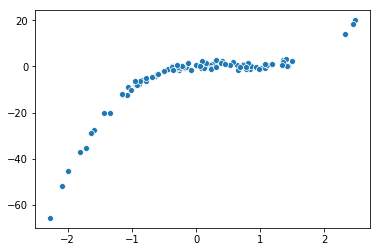

In [148]:
sns.scatterplot(X, y)

### **Best subset selection**

In [149]:
def get_rss(X, y, feature_names):
    X = sm.add_constant(X[list(feature_names)])
    model = sm.OLS(y, X[list(feature_names)]).fit()
    RSS = ((model.predict(X[list(feature_names)]) - y) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def best_model(X, y, K):
    results = []
    for combo in itertools.combinations(X.columns, K):
        results.append(get_rss(X, y, combo))
        
    all_models =  pd.DataFrame(results)
    return all_models.loc[all_models["RSS"].idxmin()]


models = pd.DataFrame(columns=['Model', 'RSS'])
for k in tqdm(range(1, len(df.columns[1:]) + 1)):
    models.loc[k] = best_model(df.iloc[:,1:], df.iloc[:,0], k)

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


In [150]:
models

,Model,RSS
1,<statsmodels.regression.linear_model.Regressio...,6596.770204
2,<statsmodels.regression.linear_model.Regressio...,219.617526
3,<statsmodels.regression.linear_model.Regressio...,116.849622
4,<statsmodels.regression.linear_model.Regressio...,110.921311
5,<statsmodels.regression.linear_model.Regressio...,108.337877
6,<statsmodels.regression.linear_model.Regressio...,105.432500
7,<statsmodels.regression.linear_model.Regressio...,104.642212
8,<statsmodels.regression.linear_model.Regressio...,96.531460
9,<statsmodels.regression.linear_model.Regressio...,96.529626
10,<statsmodels.regression.linear_model.Regressio...,96.529561


Text(0.5, 0.98, 'Best Subset Selection')

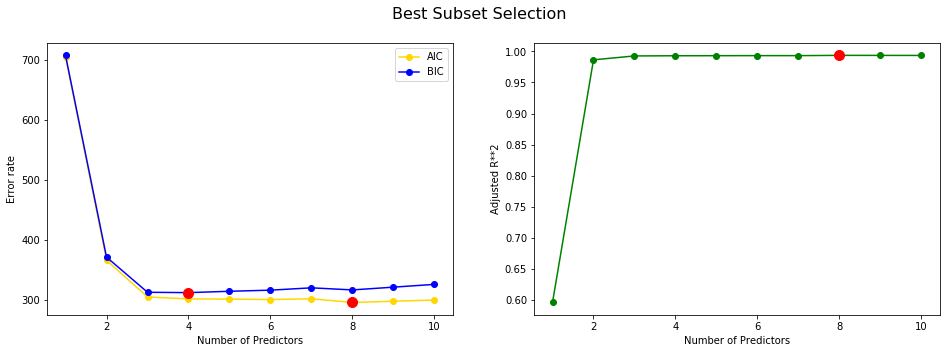

In [159]:
# Getting the metrics with list comprehension is also possible
# r_adj = [models.iloc[x, 0].rsquared_adj for x in range(len(models))]

# Get the metrics for each model
rsquared_adj = models.apply(lambda row: row[0].rsquared_adj, axis=1)
aic = models.apply(lambda row: row[0].aic, axis=1)
bic = models.apply(lambda row: row[0].bic, axis=1)

# get min and max of each metric and their indexes
min_aic_index, min_aic = min(enumerate(aic), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bic), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(rsquared_adj), key=itemgetter(1))

num_predictors = np.arange(1, len(models) + 1)

# Create a plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Add rates of bic and aic
ax1.plot(num_predictors, aic, 'gold', marker='o', label='AIC')
ax1.plot(num_predictors, bic, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'ro', markersize=10, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'ro', markersize=10, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors')
ax1.set_ylabel('Error rate')
ax1.legend(loc='best')

# Add Adj R**2
ax2.plot(num_predictors, rsquared_adj, 'g', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'ro', markersize=10, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors')
ax2.set_ylabel('Adjusted R**2')

fig.suptitle('Best Subset Selection', fontsize=16)

***
### **Forward stepwise selection**

In [180]:
def forward_select(X, y, feature_names):
    remaining_predictors = [p for p in X.columns if p not in feature_names]
    results = []
    for p in remaining_predictors:
        results.append(get_rss(X, y, feature_names+[p]))
        
    all_models =  pd.DataFrame(results)
    return all_models.loc[all_models["RSS"].idxmin()]

forward_models = pd.DataFrame(columns=['Model', 'RSS'])
feature_list = []
for k in tqdm(range(1, len(df.columns[1:]) + 1)):
    forward_models.loc[k] = forward_select(df.iloc[:,1:], df.iloc[:,0], feature_list)
    feature_list = forward_models.loc[k]['Model'].model.exog_names

100%|██████████| 10/10 [00:00<00:00, 22.93it/s]


In [183]:
forward_models

,Model,RSS
1,<statsmodels.regression.linear_model.Regressio...,6596.770204
2,<statsmodels.regression.linear_model.Regressio...,219.617526
3,<statsmodels.regression.linear_model.Regressio...,116.849622
4,<statsmodels.regression.linear_model.Regressio...,110.921311
5,<statsmodels.regression.linear_model.Regressio...,108.337877
6,<statsmodels.regression.linear_model.Regressio...,107.315009
7,<statsmodels.regression.linear_model.Regressio...,105.040631
8,<statsmodels.regression.linear_model.Regressio...,104.216786
9,<statsmodels.regression.linear_model.Regressio...,103.606776
10,<statsmodels.regression.linear_model.Regressio...,96.529561


Text(0.5, 0.98, 'Forward Stepwise Selection')

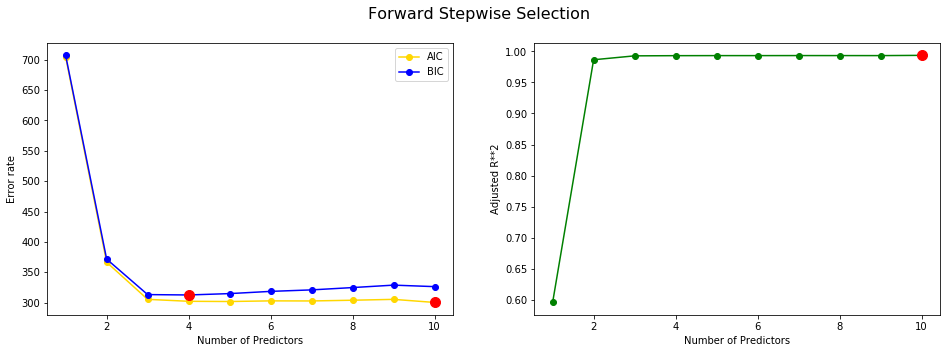

In [184]:
# Getting the metrics with list comprehension is also possible
# r_adj = [models.iloc[x, 0].rsquared_adj for x in range(len(models))]

# Get the metrics for each model
rsquared_adj = forward_models.apply(lambda row: row[0].rsquared_adj, axis=1)
aic = forward_models.apply(lambda row: row[0].aic, axis=1)
bic = forward_models.apply(lambda row: row[0].bic, axis=1)

# get min and max of each metric and their indexes
min_aic_index, min_aic = min(enumerate(aic), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bic), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(rsquared_adj), key=itemgetter(1))

num_predictors = np.arange(1, len(forward_models) + 1)

# Create a plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Add rates of bic and aic
ax1.plot(num_predictors, aic, 'gold', marker='o', label='AIC')
ax1.plot(num_predictors, bic, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'ro', markersize=10, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'ro', markersize=10, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors')
ax1.set_ylabel('Error rate')
ax1.legend(loc='best')

# Add Adj R**2
ax2.plot(num_predictors, rsquared_adj, 'g', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'ro', markersize=10, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors')
ax2.set_ylabel('Adjusted R**2')

fig.suptitle('Forward Stepwise Selection', fontsize=16)

### **Backward Stepwise Selection**

In [208]:
def backward_select(X, y, feature_names):
    results = []
    for combo in itertools.combinations(feature_names, len(feature_names)-1):
        results.append(get_rss(X, y, combo))
        
    all_models =  pd.DataFrame(results)
    return all_models.loc[all_models["RSS"].idxmin()]

backward_models = pd.DataFrame(columns=['Model', 'RSS'], index=range(1, len(df.columns[1:])))
feature_list = df.columns[1:]

while len(feature_list) > 1:
    backward_models.loc[len(feature_list)-1] = backward_select(df.iloc[:,1:], df.iloc[:,0], feature_list)
    feature_list = backward_models.loc[len(feature_list)-1]['Model'].model.exog_names

backward_models

,Model,RSS
1,<statsmodels.regression.linear_model.Regressio...,9384.62
2,<statsmodels.regression.linear_model.Regressio...,1586.43
3,<statsmodels.regression.linear_model.Regressio...,268.222
4,<statsmodels.regression.linear_model.Regressio...,140.846
5,<statsmodels.regression.linear_model.Regressio...,114.914
6,<statsmodels.regression.linear_model.Regressio...,106.156
7,<statsmodels.regression.linear_model.Regressio...,105.982
8,<statsmodels.regression.linear_model.Regressio...,96.5315
9,<statsmodels.regression.linear_model.Regressio...,96.5296


Text(0.5, 0.98, 'Backward Stepwise Selection')

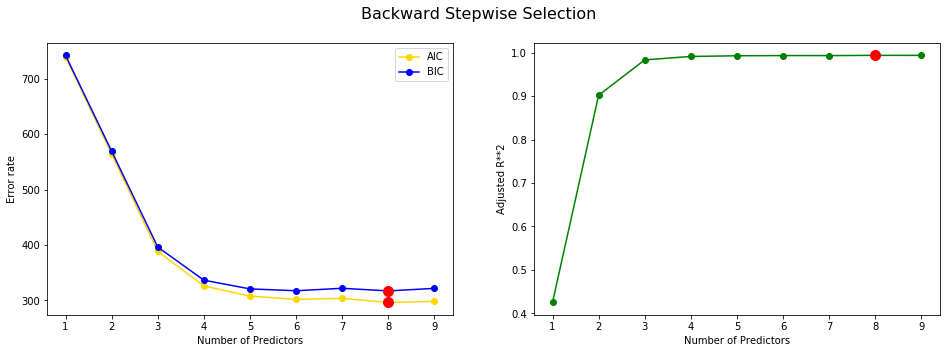

In [199]:
# Getting the metrics with list comprehension is also possible
# r_adj = [models.iloc[x, 0].rsquared_adj for x in range(len(models))]

# Get the metrics for each model
rsquared_adj = backward_models.apply(lambda row: row[0].rsquared_adj, axis=1)
aic = backward_models.apply(lambda row: row[0].aic, axis=1)
bic = backward_models.apply(lambda row: row[0].bic, axis=1)

# get min and max of each metric and their indexes
min_aic_index, min_aic = min(enumerate(aic), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bic), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(rsquared_adj), key=itemgetter(1))

num_predictors = np.arange(1, len(backward_models) + 1)

# Create a plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Add rates of bic and aic
ax1.plot(num_predictors, aic, 'gold', marker='o', label='AIC')
ax1.plot(num_predictors, bic, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'ro', markersize=10, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'ro', markersize=10, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors')
ax1.set_ylabel('Error rate')
ax1.legend(loc='best')

# Add Adj R**2
ax2.plot(num_predictors, rsquared_adj, 'g', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'ro', markersize=10, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors')
ax2.set_ylabel('Adjusted R**2')

fig.suptitle('Backward Stepwise Selection', fontsize=16)

### **Lasso**

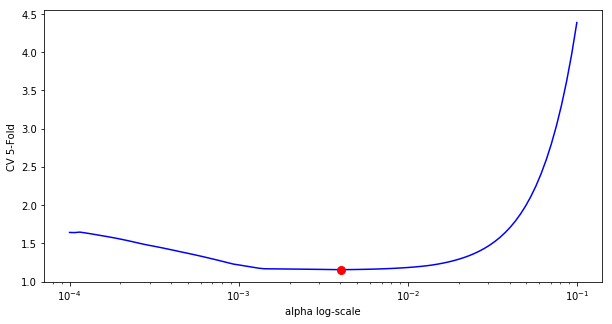

In [218]:
# Use LassoCV to perform 5-fold cross validation to determine optimal alpha
lasso_cv = LassoCV(alphas = np.logspace(-4,-1,100), normalize=True, cv=10, max_iter=10000000)
lasso_cv.fit(df.iloc[:,1:].values, df.iloc[:,0].values)

# The mse estimates are the mean aross folds (cols)
mses = np.mean(lasso_cv.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lasso_cv.alphas_,mses, color='b');
ax.plot(lasso_cv.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('CV 5-Fold');

***
## Exercise 9

In [3]:
college = sm.datasets.get_rdataset('College', package='ISLR').data
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [4]:
# This is an alternative approach to creating dummy vars.
# However, this approach creates sparse matrix, which we'll
# need to replace the original non-encoded column in the df.
# Useful in many ocassions, but for current task, Sklearn's 
# LabelEncoder is easier in this case.

#dummy = pd.get_dummies(college['Private'], prefix='Private')

In [5]:
# Encode categorical data
college['Private'] = LabelEncoder().fit_transform(college['Private'])
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [6]:
# Alternatively, use Qgrid widget
# qrid.show_grid(college, show_toolbar=True)

In [14]:
# Separate response and predictors
y = college['Apps']
X = college[college.columns.difference(['Apps'])]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [23]:
# Fit on train and predict on test
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report results
print('Coefficients:', model.coef_,
     '\n\nMean squared error: %.3f' % mean_squared_error(y_test, y_pred),
     '\nVariance score: %.3f' % r2_score(y_test, y_pred))


Coefficients: [ 1.57173182e+00 -1.38269535e-01 -8.01250884e-01  7.91910619e-02
  6.38300154e-02  9.06215594e+00 -9.60098223e-02  3.77972066e-02
 -1.16396102e-03 -1.03674278e+01 -3.69400531e+02  1.79488123e-01
  1.55672863e+01 -1.76054542e+00  5.79876935e+01 -1.92586482e+01
 -7.77582592e-02] 

Mean squared error: 618851.911 
Variance score: 0.945


### **Ridge regression**

Text(0.5, 1.0, 'Ridge coefficients as a function of the regularization')

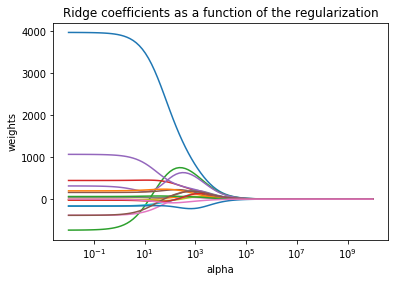

In [68]:
alphas = 10 ** np.linspace(10, -2, 100)
ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    # use astype() to suprress DataConversionWarnings
    ridge.fit(scale(X_train.astype('float64')), y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')

In [117]:
pd.Series(ridge.coef_, index=X.columns)

Accept         3969.424879
Books           -23.152745
Enroll         -739.108371
Expend          443.504620
F.Undergrad     313.128383
Grad.Rate       158.417893
Outstate       -386.133421
P.Undergrad      47.231748
Personal         -0.799146
PhD            -166.910503
Private        -165.992935
Room.Board      196.446894
S.F.Ratio        61.281089
Terminal        -24.861897
Top10perc      1065.455003
Top25perc      -386.481005
perc.alumni      -0.981797
dtype: float64

In [69]:
# Scaling data. StandardScaler is same as scale(), only StandardScaler support Transformer API
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\Ali Sina\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ali Sina\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\Ali Sina\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  """


In [84]:
ridgecv = RidgeCV(alphas=alphas, cv=5).fit(X_train, y_train)
ridgecv.alpha_

6.135907273413163

In [85]:
# R-squared
ridgecv.score(X_test, y_test)

0.9433962398548505

In [86]:
# MSE
mean_squared_error(y_test, ridgecv.predict(X_test))

631187.2100547701

**Conclusion:** Ridge with CV does not perform better than ordinary least squares regression.

Check out [`glmnet`](https://github.com/civisanalytics/python-glmnet) and [`glmnet_python`](https://glmnet-python.readthedocs.io/en/latest/glmnet_vignette.html) for running R-style regularization.

### **Lasso regularization**

Text(0.5, 1.0, 'Lasso coefficients as a function of the regularization')

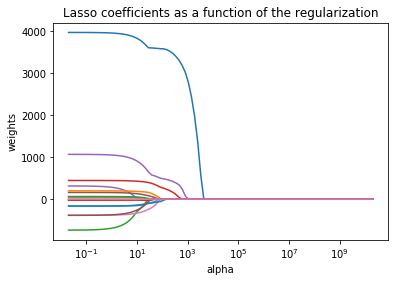

In [101]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train) #no need coz already scaled
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')

In [102]:
# Lasso with CV
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000).fit(X_train, y_train)
lassocv.alpha_

12.570140969896554

In [104]:
# R-squared
lassocv.score(X_test, y_test)

0.9438144453773949

In [105]:
# MSE
mean_squared_error(y_test, lassocv.predict(X_test))

626523.8100204366

In [106]:
pd.Series(lassocv.coef_, index=X.columns)

Accept         3795.535619
Books            -0.899960
Enroll         -243.407363
Expend          421.461542
F.Undergrad       0.000000
Grad.Rate       120.579647
Outstate       -321.858253
P.Undergrad      32.833553
Personal         -0.000000
PhD            -133.683012
Private        -146.824863
Room.Board      179.354840
S.F.Ratio        44.361216
Terminal        -26.176915
Top10perc       867.781003
Top25perc      -231.802446
perc.alumni      -4.616193
dtype: float64

### **Principal Component Analysis**

Python does not have PCR like R, but can do like following:

In [199]:
# Initialize PCA instance
pca = PCA()

# Transform X_train (Data is scaled here already)
X_train_reduced = pca.fit_transform(X_train)

Variance (% cumulative) explained by the principal components:

In [120]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 30.89,  57.07,  64.32,  70.07,  75.56,  80.62,  84.4 ,  87.68,
        90.52,  92.85,  94.96,  96.8 ,  97.83,  98.74,  99.4 ,  99.85,
       100.01])

Text(0, 0.5, 'MSE')

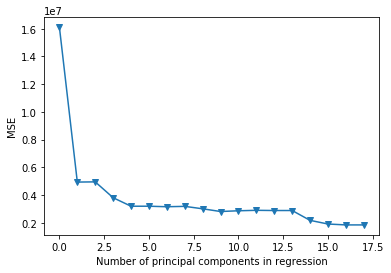

In [211]:
# 10-fold CV, with shuffle
n = len(X_train_reduced)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
#score = -1 * cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
#mse.append(score)

# Calculate MSE using CV for the 18 principle components, adding one component at the time.
for i in np.arange(1, 19):
    score = -1 * cross_val_score(regr, X_train_reduced[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')

In [145]:
# Alternatively, define a function to do PCR is better
def pcr(X, y, pc):
    ''' Principal Component Regression in Python'''
    ''' Step 1: PCA on input data'''

    # Define the PCA object
    pca = PCA()

    # Preprocessing (1): first derivative
    X_pca = pca.fit_transform(scale(X))[:,:pc]

    ''' Step 2: regression on selected principal components'''

    # Create linear regression object
    regr = LinearRegression()
    
    # Fit
    regr.fit(X_pca, y)

    # Calibration
    y_train = regr.predict(X_pca)

    # Cross-validation
    y_cv = cross_val_predict(regr, X_pca, y, cv=20)

    # Calculate scores for training and cross-validation
    score_train = r2_score(y, y_train)
    score_cv = r2_score(y, y_cv)

    # Calculate mean square error for training and cross validation
    mse_train = mean_squared_error(y, y_train)
    mse_cv = mean_squared_error(y, y_cv)

    return(y_cv, score_train, score_cv, mse_train, mse_cv)

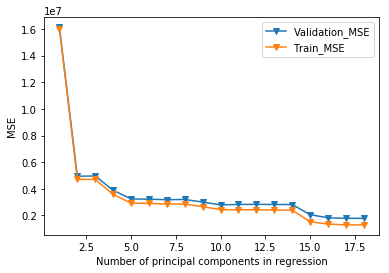

In [210]:
mse_train = []
mse_cv = []

# Calculate MSE using CV for the 18 principle components, adding one component at the time.
for i in np.arange(1, 19):
    results =  pcr(X_train, y_train ,i)
    mse_train.append(results[3])
    mse_cv.append(results[4])
    
# Plot results    
plt.plot(np.arange(1, 19), mse_cv, '-v', label = 'Validation_MSE')
plt.plot(np.arange(1, 19), mse_train, '-v', label = 'Train_MSE')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.legend()
plt.show()

The lowest MSE occurs with principal components $M = 15$.

In [187]:
pca = PCA(n_components=15)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_train_reduced, y_train)

# Prediction with test data
pred = regr.predict(X_test_reduced)
mean_squared_error(y_test, pred)

796210.0721906136

### **Partial Least Squares**

Text(0, 0.5, 'MSE')

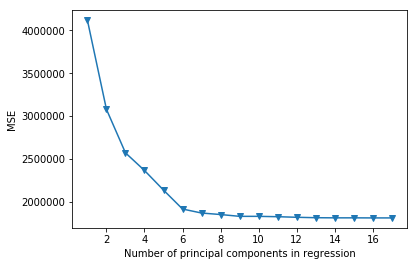

In [214]:
# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

for i in np.arange(1, 18):
    pls = PLSRegression(n_components=i)
    score = -1 * cross_val_score(pls, X_train, y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.arange(1, 18), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')

In [215]:
pls = PLSRegression(n_components=6)
pls.fit(X_train, y_train)

mean_squared_error(y_test, pls.predict(X_test))

647912.4977131289

**Conclusion:** None of these methods the OLS Linear regression. In this case, nothing beats *simple*.  :)